In [1]:
import keras
keras.__version__

'2.10.0'

In [ ]:
#드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

#현재 작업 위치 이동
#띄어쓰기에 \붙일 것
%cd /content/drive/Othercomputers/내\ 노트북/Devpy_work/02.멀티캠퍼스

Mounted at /content/drive
/content/drive/Othercomputers/내 노트북/Devpy_work/02.멀티캠퍼스


In [ ]:
이미지 전처리- 테스트 훈련용트레인 검증용 각각 폴더에 분류하고
이미지 크롤링해서 사이즈, 파일명 등 통일하기 

메모리에 올리고 전처리를 하고 투입하기에 메모리에 무리임. 
그래서 자원에 대한 문제,

# 데이터 증강(Data Augmentation)


* 매우 적은 데이터를 사용해 이미지 분류 모델을 훈련하는 일은 흔한 경우입니다. 
* 보통 '적은' 샘플이란 수백 개에서 수만 개 사이를 의미합니다. 

---

## 디렉토리에 데이터 세트 구성하기
* 지금까지 사용한 데이터 세트는 텐서플로나 판다스, 시본등 라이브러리에 있는 데이터였습니다. 
* **데이터 세트가 하드 드라이브에 있을 때** 모든 데이터를 메모리에 올려서 사용할 수 없습니다. 
* 디렉토리에 있는 데이터들을 효과적으로 메모리에 올려서 학습할 수 있는 시스템이 필요합니다. 
* 디렉토리에서 데이터 추출에서 학습까지 순차적으로 반복해서 진행될 수 있도록 파이프라인을 구축해 봅시다.

In [2]:
## 이미 사용할 데이터 구분 다 해놨을 때.
## 디렉토리 경로 정보만 필요할 때 사용

import os, shutil

# 원본 데이터셋을 압축 해제한 디렉터리 경로
# original_dataset_dir = './dataset/cats_and_dogs/train'

# 소규모 데이터셋을 저장할 디렉터리 (베이스 디렉터리)
base_dir = './data/cats_and_dogs_small'

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')

validation_dir = os.path.join(base_dir, 'validation')

test_dir = os.path.join(base_dir, 'test')


# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')


# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')


# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')


# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')


# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')


In [3]:
train_cats_dir


'./data/cats_and_dogs_small\\train\\cats'

In [4]:
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))

훈련용 고양이 이미지 전체 개수: 1000


In [5]:
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))

훈련용 강아지 이미지 전체 개수: 1000


In [6]:
print('검증용 고양이 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))

검증용 고양이 이미지 전체 개수: 500


In [7]:
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))

검증용 강아지 이미지 전체 개수: 500


In [8]:
print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))

테스트용 고양이 이미지 전체 개수: 500


In [9]:
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))

테스트용 강아지 이미지 전체 개수: 500


## 데이터 전처리
[전처리 종류]

1.	이미지 사이즈 통일 150 X 150
2.	부동 소수 타입의 텐서로 변환
3.	픽셀 값(0에서 255 사이)의 스케일을 [0, 1] 사이로 조정(신경망은 작은 입력 값을 선호합니다)

* `ImageDataGenerator` 클래스는 디스크에 있는 이미지 파일을 전처리된 배치 텐서로 자동으로 바꾸어주는 파이썬 제너레이터를 만들어 줍니다.

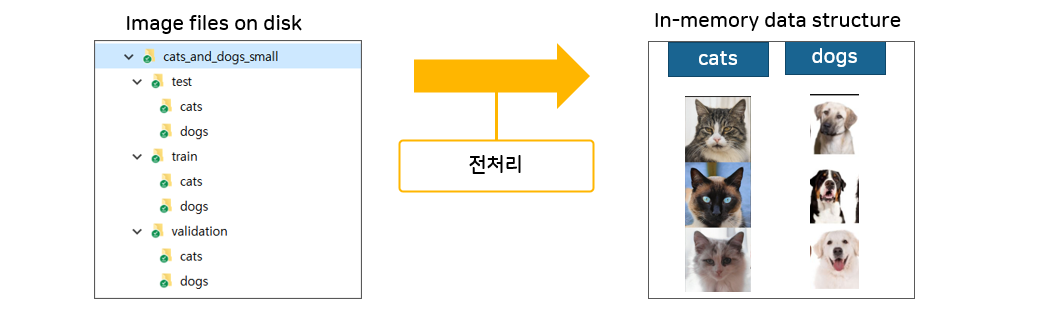

In [ ]:
배치사이즈(예, 50장)만큼만 메모리에 올리고 전처리도 동시에 작동
이러한 파이프라인이 생기게 함

50장만 메모리 올려 훈련하고 그다음 50장 메모리에 올려 훈련
`ImageDataGenerator` for문 돌려서 반복실행 

전처는 사이즈 스케일링 정규화 등

In [10]:
from keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale=1./255) # 디렉터리로부터 흐름을 만든다
# test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(         # 이미지 크기 통일해서 지정, 배치사이즈, 캣앤독 2개니까 이진레이블.
        train_dir,              # 훈련 디렉터리                
        target_size=(150, 150), # 모든 이미지를 150 × 150 크기로 바꿈
        batch_size=20,          #한번에 가지고 올 이미지 장 수
        class_mode='binary')    # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요

# validation_generator = test_datagen.flow_from_directory(
#         validation_dir,
#         target_size=(150, 150),
#         batch_size=20,
#         class_mode='binary')

# 개와 고양이니까 2개 클래스. 아~ 2천장이미지가 2개 클래스로 이루어졋구나

Found 2000 images belonging to 2 classes.


* 이 제너레이터의 출력 하나는 150 × 150 RGB 이미지의 배치(`(20, 150, 150, 3)` 크기)와 이진 레이블의 배치(`(20,)` 크기)입니다.
* 각 배치에는 20개의 샘플(배치 크기)이 있습니다. 
* 제너레이터는 이 배치를 무한정 만들어 냅니다. 
* 타깃 폴더에 있는 이미지를 끝없이 반복합니다. 따라서 반복 루프안의 어디에선가 `break` 문을 사용해야 합니다.

In [11]:
#제너레이터 사용방법
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

# 20장씩, 150x150, 3:컬러이미지
# 레이블도 쉐입맞춰서. 20장샘플수.

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


## 데이터 증강하기(Augmentation)

* 과대적합 해결로 데이터 양을 증가시키는 효과가 목적입니다. 
* 기존의 데이터에 여러 가지 랜덤한 변환을 적용하여 샘플을 늘립니다.
* 늘리고, 돌리고, 상하좌우 이동하고, 확대축소하고..... 
* 모델이 데이터의 여러 측면을 학습하면 일반화에 도움

[ImageDataGenerator] 파라미터 설정
* `rotation_range`는 랜덤하게 사진을 회전시킬 각도 범위입니다(0-180 사이).
* `width_shift_range`와 `height_shift_range`는 사진을 수평과 수직으로 랜덤하게 평행 이동시킬 범위입니다(전체 넓이와 높이에 대한 비율).
* `shear_range`는 랜덤하게 전단 변환을 적용할 각도 범위입니다.
* `zoom_range`는 랜덤하게 사진을 확대할 범위입니다.
* `horizontal_flip`은 랜덤하게 이미지를 수평으로 뒤집습니다. 수평 대칭을 가정할 수 있을 때 사용합니다(예를 들어, 풍경/인물 사진).
* `fill_mode`는 회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀을 채울 전략입니다.

증식된 이미지 샘플을 살펴보죠:


In [12]:
datagen = ImageDataGenerator(
      rotation_range=40, # 랜덤하게 사진을 회전시킬 각도 범위(0~180)
      width_shift_range=0.2, #사진을 수평과 수직으로 랜덤하게 평행 이동시킬 범위
      height_shift_range=0.2,
      shear_range=0.2, #랜덤하게 전단 변환을 적용할 각도 범위
      zoom_range=0.2,   #랜덤하게 사진을 확대할 범위
      horizontal_flip=True, #랜덤하게 이미지를 수평으로 뒤집기
      fill_mode='nearest') #회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀을 채울 전략

## 데이터 증강 디버깅
* Generator를 이용해서 학습하기 전, 먼저 변형된 이미지에 이상한 점이 없는지 확인해야 합니다. 
* 이를 돕기 위해 flow라는 함수를 제공합니다.
* 증강이 잘못된 경우를 확인하고 파라미터 설정을 재 조정합니다. 

In [13]:
# 이미지 전처리 유틸리티 모듈
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

#훈련용 고양이 이미지 파일
fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

In [14]:
fnames

['./data/cats_and_dogs_small\\train\\cats\\cat.0.jpg',
 './data/cats_and_dogs_small\\train\\cats\\cat.1.jpg',
 './data/cats_and_dogs_small\\train\\cats\\cat.10.jpg',
 './data/cats_and_dogs_small\\train\\cats\\cat.100.jpg',
 './data/cats_and_dogs_small\\train\\cats\\cat.101.jpg',
 './data/cats_and_dogs_small\\train\\cats\\cat.102.jpg',
 './data/cats_and_dogs_small\\train\\cats\\cat.103.jpg',
 './data/cats_and_dogs_small\\train\\cats\\cat.104.jpg',
 './data/cats_and_dogs_small\\train\\cats\\cat.105.jpg',
 './data/cats_and_dogs_small\\train\\cats\\cat.106.jpg',
 './data/cats_and_dogs_small\\train\\cats\\cat.107.jpg',
 './data/cats_and_dogs_small\\train\\cats\\cat.108.jpg',
 './data/cats_and_dogs_small\\train\\cats\\cat.109.jpg',
 './data/cats_and_dogs_small\\train\\cats\\cat.11.jpg',
 './data/cats_and_dogs_small\\train\\cats\\cat.110.jpg',
 './data/cats_and_dogs_small\\train\\cats\\cat.111.jpg',
 './data/cats_and_dogs_small\\train\\cats\\cat.112.jpg',
 './data/cats_and_dogs_small\\train\\

In [15]:
# 증식할 이미지 선택합니다
img_path = fnames[3]
img_path

'./data/cats_and_dogs_small\\train\\cats\\cat.100.jpg'

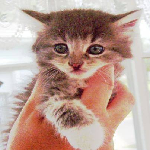

In [16]:
# 이미지를 읽고 크기를 변경합니다
img = image.load_img(img_path, target_size=(150, 150))
img

In [17]:
# (150, 150, 3) 크기의 넘파이 배열로 변환합니다
x = image.img_to_array(img)
x.shape

(150, 150, 3)

In [18]:
import numpy as np
# (1, 150, 150, 3) 크기로 변환합니다
x=np.expand_dims(x, axis=0)
x.shape

(1, 150, 150, 3)

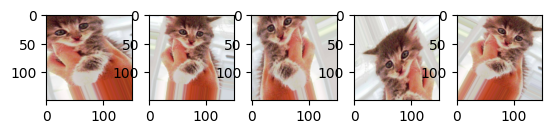

In [19]:
i = 1
for batch in datagen.flow(x, batch_size=20):

    plt.subplot(1, 5, i)
    img = image.array_to_img(batch[0])
    plt.imshow(img)

    i += 1
    
    if i == 6:
        break

plt.show()

## 종합코드

In [20]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

In [21]:
datagen = ImageDataGenerator(
    rescale=1./255,    #전처리
    rotation_range=40, # 랜덤하게 사진을 회전시킬 각도 범위(0~180)
    width_shift_range=0.2, #사진을 수평과 수직으로 랜덤하게 평행 이동시킬 범위
    height_shift_range=0.2,
    shear_range=0.2, #랜덤하게 전단 변환을 적용할 각도 범위
    zoom_range=0.2,   #랜덤하게 사진을 확대할 범위
    horizontal_flip=True, #랜덤하게 이미지를 수평으로 뒤집기
    fill_mode='nearest') #회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀을 채울 전략

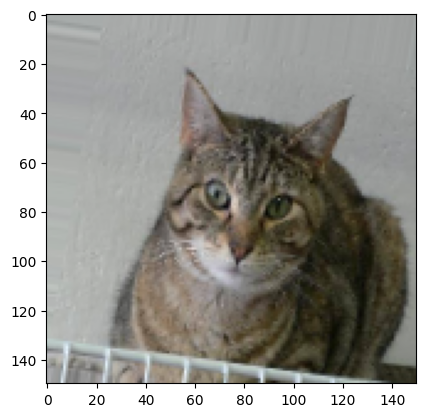

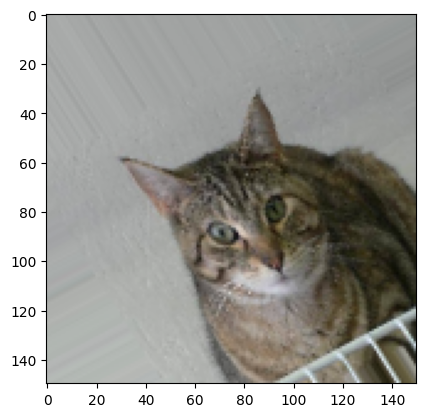

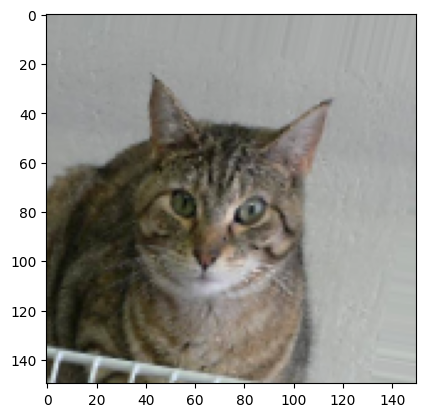

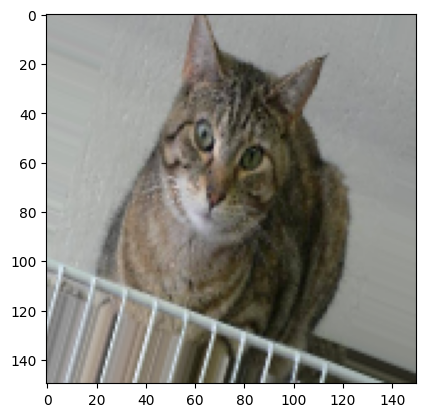

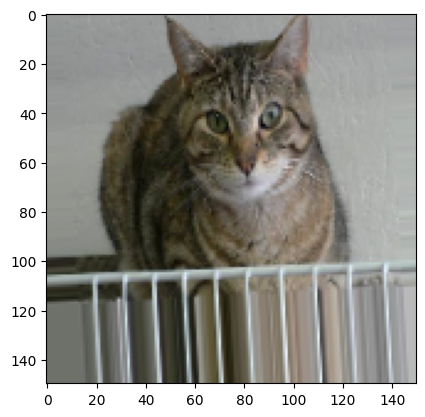

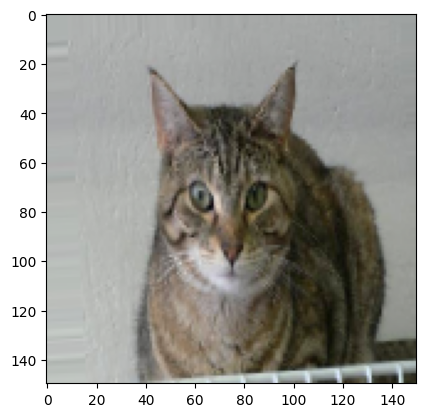

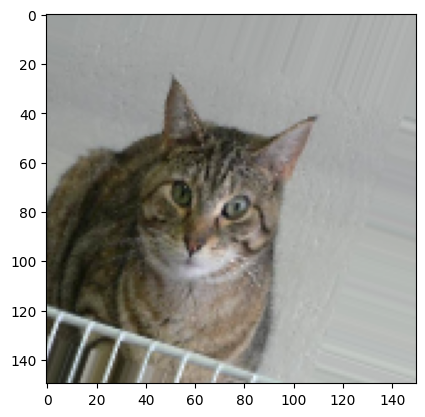

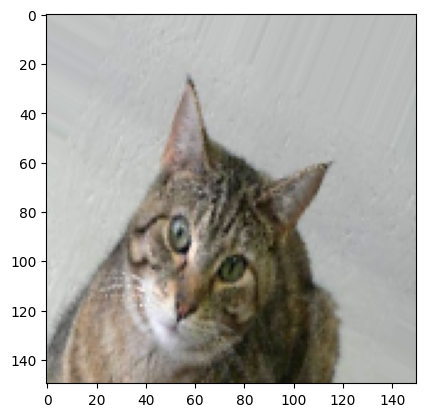

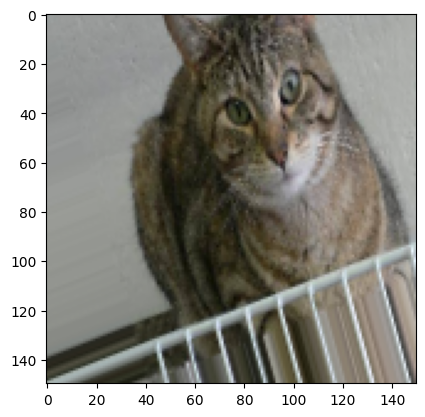

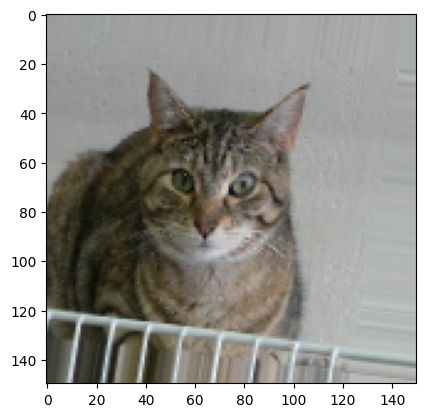

In [23]:

fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

# 증식할 이미지 선택합니다 (7번째 데이터)
img_path = fnames[6]

# 이미지를 읽고 크기를 변경합니다
img = image.load_img(img_path, target_size=(150, 150))

# (150, 150, 3) 크기의 넘파이 배열로 변환합니다
x = image.img_to_array(img)

# (1, 150, 150, 3) 크기로 변환합니다
x=np.expand_dims(x, axis=0)

# flow() 메서드는 랜덤하게 변환된 이미지의 배치를 생성합니다.
# 무한 반복되기 때문에 어느 지점에서 중지해야 합니다!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 10 == 0:
        break

plt.show()

* 데이터 증식을 사용하여 새로운 네트워크를 훈련시킬 때 네트워크에 같은 입력 데이터가 두 번 주입되지 않습니다. 
* 하지만 적은 수의 원본 이미지에서 만들어졌기 때문에 여전히 입력 데이터들 사이에 상호 연관성이 큽니다. 
* 즉, 새로운 정보를 만들어낼 수 없고 단지 기존 정보의 재조합만 가능합니다. 
* 그렇기 때문에 완전히 과대적합을 제거하기에 충분하지 않을 수 있습니다. 
* 과대적합을 더 억제하기 위해 완전 연결 분류기 직전에 `Dropout` 층을 추가하겠습니다

In [ ]:
적은 수의 이미지라도 다양하게 훈련해서 과적합을 억제.